<a href="https://colab.research.google.com/github/RichieDatalyst/FurGenius/blob/main/FurGenius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries and Loading Dataset**

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
df = pd.read_csv("/content/animal_nutrition_dataset.csv")

**Dataset Information**

In [2]:
# Display basic info and first few rows
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Animal_ID                 3000 non-null   int64  
 1   Species                   3000 non-null   object 
 2   Breed                     3000 non-null   object 
 3   Age                       3000 non-null   int64  
 4   Gender                    3000 non-null   object 
 5   Weight                    3000 non-null   float64
 6   Height                    3000 non-null   float64
 7   Medical_Condition         1477 non-null   object 
 8   Caloric_Intake            3000 non-null   float64
 9   Protein_Intake            3000 non-null   float64
 10  Fat_Intake                3000 non-null   float64
 11  Carbohydrate_Intake       3000 non-null   float64
 12  Fiber_Intake              3000 non-null   float64
 13  Water_Intake              3000 non-null   float64

**Checking Missing Values**

In [3]:
# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Medical_Condition    1523
dtype: int64


**Handling Missing Values**

In [4]:
# ----------------------------
# 1. Handling Missing Values
# ----------------------------
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# For numerical columns: fill missing values with the median
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# For categorical columns: fill missing values with the mode
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

**Feature Scaling**

In [5]:
# ----------------------------
# 2. Feature Scaling
# ----------------------------
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

**Categorical Encoding**

In [6]:
# ----------------------------
# 3. Categorical Encoding (excluding text columns)
# ----------------------------
# Define text columns that should be processed separately
text_cols = ['Veterinary_Notes', 'Prescription', 'Dietary_Recommendations']

# Other categorical columns to encode (exclude text columns)
other_cat_cols = [col for col in cat_cols if col not in text_cols]

# Apply One-Hot Encoding to non-text categorical columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat = pd.DataFrame(ohe.fit_transform(df[other_cat_cols]),
                           columns=ohe.get_feature_names_out(other_cat_cols))
# Combine encoded categorical features with the rest of the dataframe
df = pd.concat([df.drop(columns=other_cat_cols), encoded_cat], axis=1)


**Multicollinearity: Variance Inflation Factor (VIF) Analysis**

In [7]:
# ----------------------------
# 4. Multicollinearity: Variance Inflation Factor (VIF) Analysis
# ----------------------------
# Compute VIF only for the original numerical features (which have been scaled)
vif_data = pd.DataFrame()
vif_data["Feature"] = df[num_cols].columns
vif_data["VIF"] = [variance_inflation_factor(df[num_cols].values, i)
                   for i in range(len(num_cols))]
print("VIF for numerical features:")
print(vif_data)

# Define a threshold for VIF (e.g., 10). Drop features exceeding this threshold.
high_vif = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
print("Dropping highly collinear numerical features:", high_vif)
df.drop(columns=high_vif, inplace=True, errors='ignore')


VIF for numerical features:
                     Feature        VIF
0                  Animal_ID   1.007841
1                        Age   1.005284
2                     Weight  99.080527
3                     Height   5.510293
4             Caloric_Intake  50.631516
5             Protein_Intake  20.087418
6                 Fat_Intake   8.937745
7        Carbohydrate_Intake  19.217692
8               Fiber_Intake   1.005029
9               Water_Intake   1.003343
10      Body_Condition_Score   1.005981
11            Metabolic_Rate   1.006196
12                Heart_Rate   1.004433
13          Respiratory_Rate   1.008101
14               Temperature   1.004869
15   Blood_Pressure_Systolic   1.007789
16  Blood_Pressure_Diastolic   1.003053
Dropping highly collinear numerical features: ['Weight', 'Caloric_Intake', 'Protein_Intake', 'Carbohydrate_Intake']


**Text Data Processing and Download necessary NLTK data files**

In [8]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# ----------------------------
# 5. Text Data Processing
# ----------------------------
# Define NLP preprocessing function for text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure text is a string and handle missing or non-string values
    if pd.isnull(text) or not isinstance(text, str) or text.strip() == "":
        return "empty"

    text = str(text).strip().lower()  # Lowercase and remove extra spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization

    return " ".join(tokens) if tokens else "empty"

# Define text columns to process
text_cols = ['Veterinary_Notes', 'Prescription', 'Dietary_Recommendations']
for col in text_cols:
    df[col + "_Cleaned"] = df[col].astype(str).apply(preprocess_text)

# Display a sample of processed text fields
print("Sample processed text data:")
print(df[[col + "_Cleaned" for col in text_cols]].head())

# Final preprocessed dataset info
print("Data Preprocessing completed. Final dataset shape:", df.shape)

Sample processed text data:
                            Veterinary_Notes_Cleaned  \
0  patient exhibit mild symptom fatigue slight cough   
1             patient recovering well recent surgery   
2  sign obesity detected recommend dietary adjust...   
3             evidence kidney issue test recommended   
4       significant abnormality observed examination   

                         Prescription_Cleaned  \
0  provide vitamin supplement routine checkup   
1           administer iu insulin twice daily   
2           administer iu insulin twice daily   
3       recommend lowprotein diet added fiber   
4           administer iu insulin twice daily   

                    Dietary_Recommendations_Cleaned  
0  increase vegetable intake reduce fat consumption  
1      regular monitoring dietary adjustment needed  
2        ensure proper hydration exercise regularly  
3      regular monitoring dietary adjustment needed  
4         maintain balanced diet controlled calorie  
Data Preprocessi

In [10]:
df.to_csv("preprocessed_animal_healthcare_data.csv", index=False)

**EDA Libraries and Loading Preprocessed Dataset for EDA and performing EDA using Scatter Plots, Bar Charts, Histogram, Box Plots and Heatmaps**





In [11]:
# Import required libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For reproducibility in plots
sns.set(style="whitegrid")

# ----------------------------------------
# Load the final preprocessed dataset
# ----------------------------------------
# Here we assume you saved the final dataset as "preprocessed_animal_nutrition.csv"
# If needed, you can use your DataFrame from Step 1.
df_processed = pd.read_csv("/content/preprocessed_animal_healthcare_data.csv")
print("Preprocessed Dataset Shape:", df_processed.shape)
print(df_processed.head())

# ----------------------------------------
# (Optional) For EDA, load a copy of the original synthetic dataset
# (to retrieve original categorical variables for visualization)
df_original = pd.read_csv("/content/animal_nutrition_dataset.csv")
print("Original Dataset Shape:", df_original.shape)


Preprocessed Dataset Shape: (3000, 87)
   Animal_ID       Age    Height  Fat_Intake  Fiber_Intake  Water_Intake  \
0  -1.731474 -0.609328 -0.992720   -0.646466     -0.110384     -0.577031   
1  -1.730319 -1.486143 -0.618977   -0.619904      0.424044     -1.247561   
2  -1.729164 -0.258602 -0.416365   -0.661810      0.675540     -0.202579   
3  -1.728009  1.319665  1.577508    0.706133      0.993402      1.539059   
4  -1.726855  0.968939 -0.890652   -0.644623     -0.679743     -1.160479   

   Body_Condition_Score  Metabolic_Rate  Heart_Rate  Respiratory_Rate  ...  \
0              1.166136        0.729764   -1.008350         -1.490485  ...   
1             -0.763062       -0.406658    0.462382         -1.315696  ...   
2              0.780296        0.387455   -1.498594          0.781773  ...   
3             -0.377223        0.345248   -0.097897          0.781773  ...   
4              1.551976        1.702849    1.302800         -1.665274  ...   

   Stress_Level_Low  Stress_Level_M

In [12]:
# We'll use the original 'Species', 'Medical_Condition', and 'Dietary_Category' columns for categorical visualizations.
# Note: In our preprocessed dataset these columns have been one-hot encoded,
# so for EDA we re-use the originals.
df_original_for_cat = df_original[['Species', 'Medical_Condition', 'Dietary_Category']]

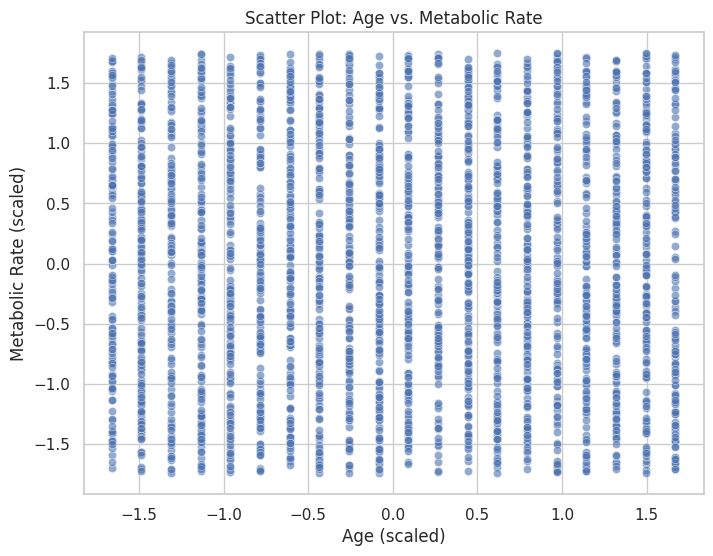

In [13]:
# ----------------------------------------
# 1. Scatter Plots
# ----------------------------------------
# Example scatter plot: Age vs. Metabolic_Rate (both are numerical and still available)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_processed, x='Age', y='Metabolic_Rate', alpha=0.6)
plt.title("Scatter Plot: Age vs. Metabolic Rate")
plt.xlabel("Age (scaled)")
plt.ylabel("Metabolic Rate (scaled)")
plt.grid(True)
plt.show()

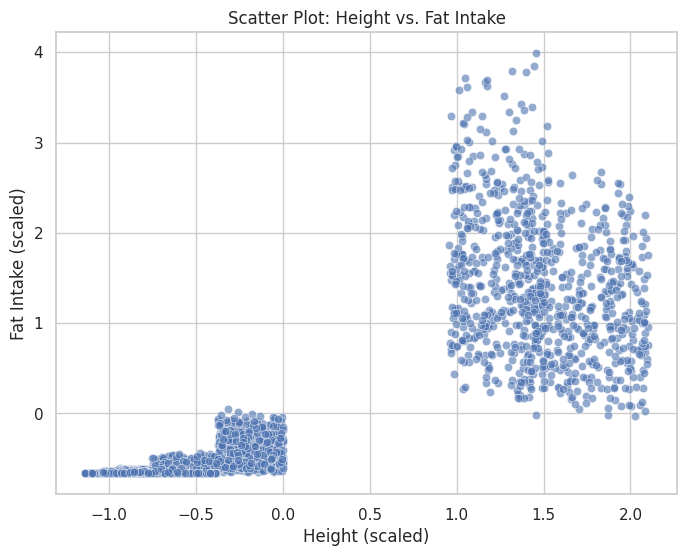

In [14]:
# Another scatter plot: Height vs. Fat_Intake (alternative to Weight vs. Caloric_Intake)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_processed, x='Height', y='Fat_Intake', alpha=0.6)
plt.title("Scatter Plot: Height vs. Fat Intake")
plt.xlabel("Height (scaled)")
plt.ylabel("Fat Intake (scaled)")
plt.grid(True)
plt.show()

<ipython-input-15-2b754e425731>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diet_counts.index, y=diet_counts.values, palette="viridis")


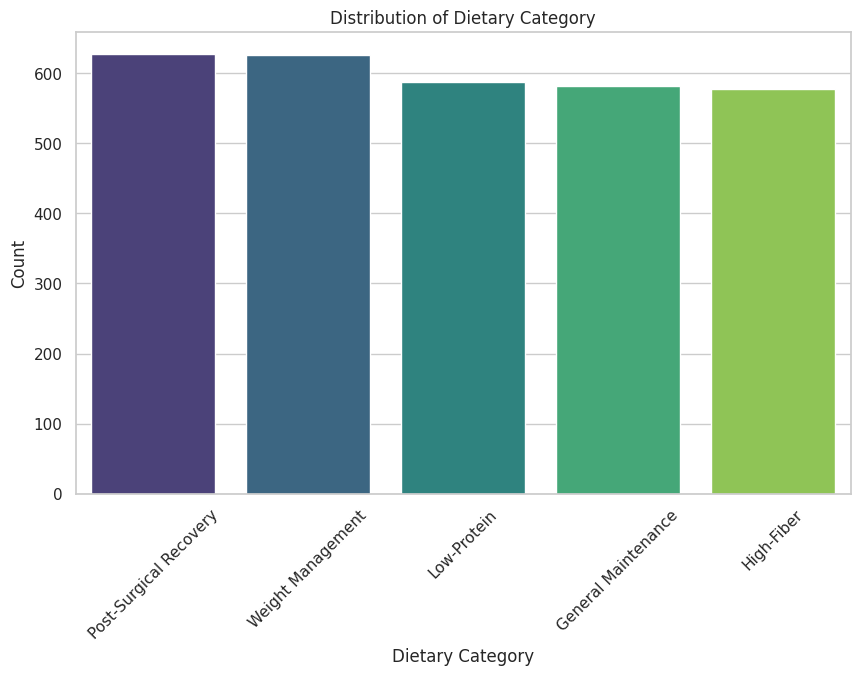

In [15]:
# ----------------------------------------
# 2. Bar Charts
# ----------------------------------------
# Bar chart: Distribution of Dietary Category (from original data)
plt.figure(figsize=(10, 6))
diet_counts = df_original_for_cat['Dietary_Category'].value_counts()
sns.barplot(x=diet_counts.index, y=diet_counts.values, palette="viridis")
plt.title("Distribution of Dietary Category")
plt.xlabel("Dietary Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<ipython-input-16-b5b1f65862b4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=med_counts.index, y=med_counts.values, palette="magma")


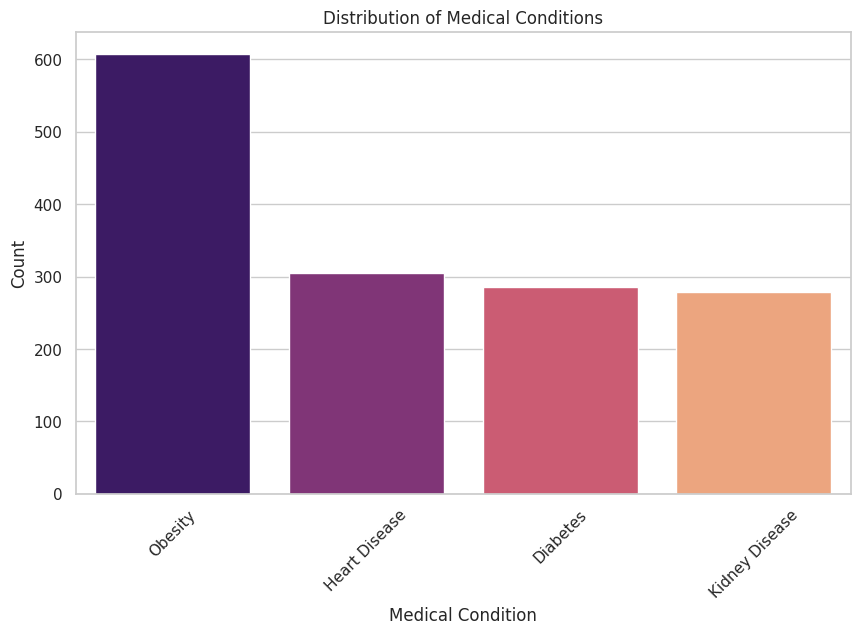

In [16]:
# Bar chart: Distribution of Medical Conditions
plt.figure(figsize=(10, 6))
med_counts = df_original_for_cat['Medical_Condition'].value_counts()
sns.barplot(x=med_counts.index, y=med_counts.values, palette="magma")
plt.title("Distribution of Medical Conditions")
plt.xlabel("Medical Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

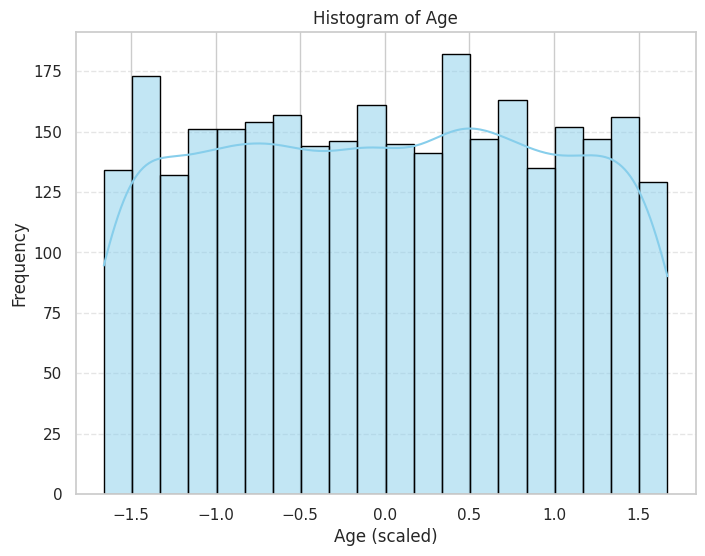

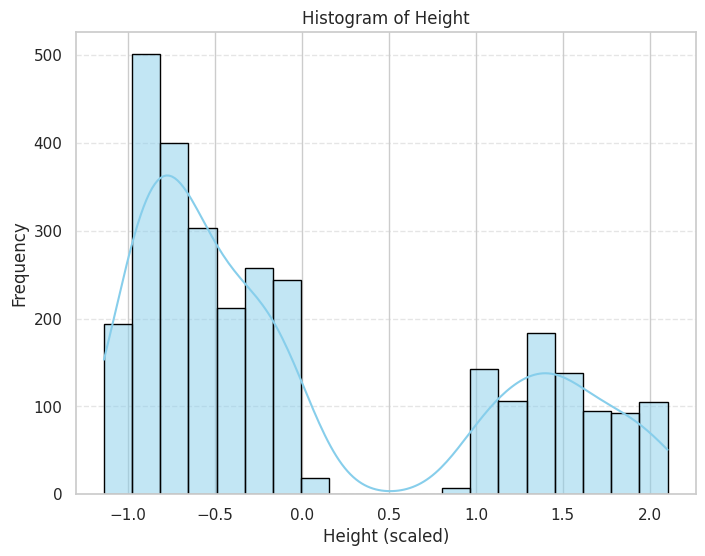

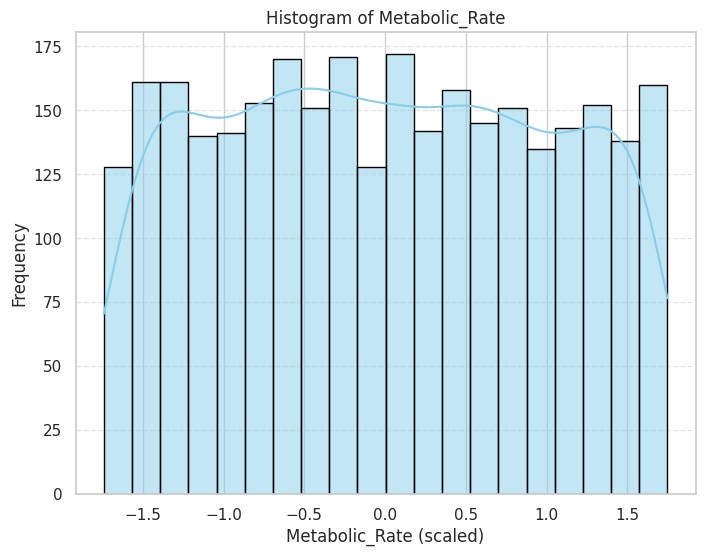

In [17]:
# ----------------------------------------
# 3. Histograms
# ----------------------------------------
# Plot histograms for a few key numerical features:
features_to_plot = ['Age', 'Height', 'Metabolic_Rate']
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_processed[feature], bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {feature}")
    plt.xlabel(f"{feature} (scaled)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

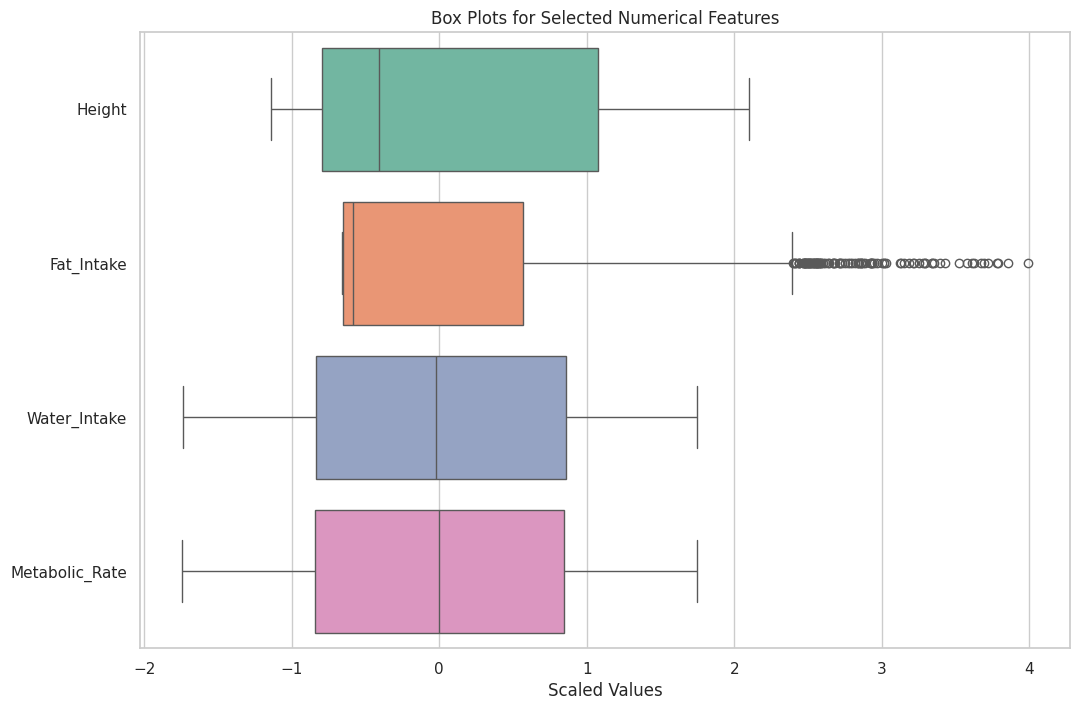

In [18]:
# ----------------------------------------
# 4. Box Plots
# ----------------------------------------
# Box plots for selected numerical features to detect outliers
features_for_box = ['Height', 'Fat_Intake', 'Water_Intake', 'Metabolic_Rate']
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_processed[features_for_box], orient='h', palette="Set2")
plt.title("Box Plots for Selected Numerical Features")
plt.xlabel("Scaled Values")
plt.show()

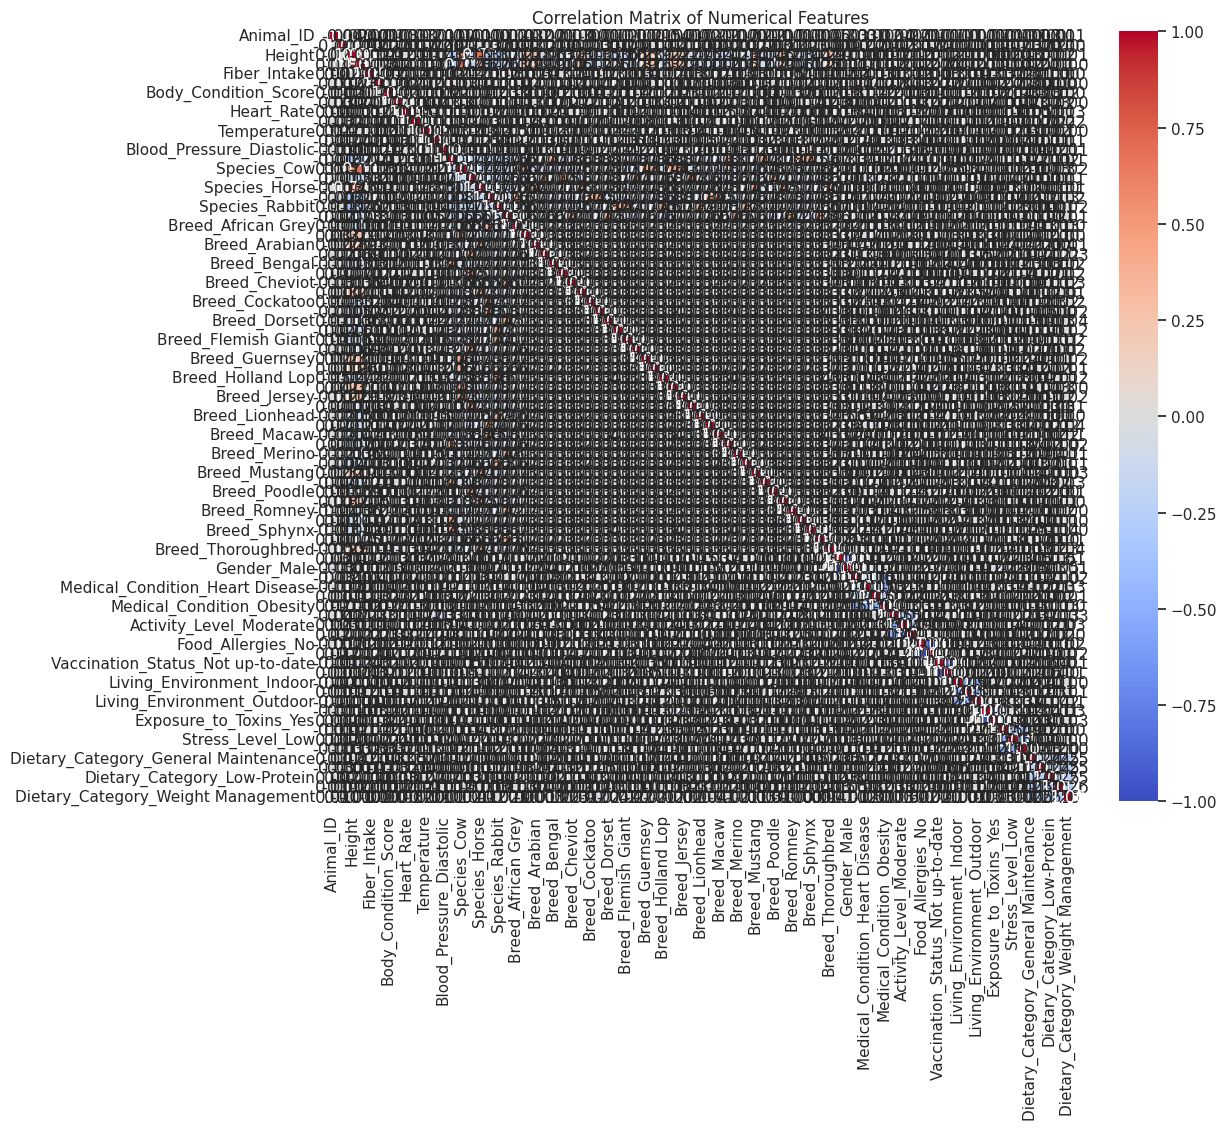

In [19]:
# ----------------------------------------
# 5. Heatmaps
# ----------------------------------------
# Before computing the correlation matrix, ensure that all columns used are numerical
# Exclude text features and any column with non-numeric values
numeric_cols_for_corr = df_processed.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df_processed[numeric_cols_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Additional Insights**

In [20]:
# Additional Insights:
# - Display summary statistics for key features
print("Summary Statistics:")
print(df_processed[numeric_cols_for_corr].describe())

# - Print out the correlation matrix for further insights
print("Correlation Matrix:")
print(corr_matrix)

Summary Statistics:
         Animal_ID           Age        Height    Fat_Intake  Fiber_Intake  \
count  3000.000000  3.000000e+03  3.000000e+03  3.000000e+03  3.000000e+03   
mean      0.000000  9.947598e-17  2.794801e-16  7.105427e-18 -3.967197e-16   
std       1.000167  1.000167e+00  1.000167e+00  1.000167e+00  1.000167e+00   
min      -1.731474 -1.661506e+00 -1.139623e+00 -6.620100e-01 -1.710177e+00   
25%      -0.865737 -7.846909e-01 -7.950216e-01 -6.507224e-01 -8.587589e-01   
50%       0.000000 -8.323896e-02 -4.082568e-01 -5.856704e-01 -1.258061e-02   
75%       0.865737  7.935759e-01  1.077084e+00  5.675862e-01  8.510627e-01   
max       1.731474  1.670391e+00  2.102543e+00  3.990278e+00  1.779326e+00   

       Water_Intake  Body_Condition_Score  Metabolic_Rate    Heart_Rate  \
count  3.000000e+03          3.000000e+03    3.000000e+03  3.000000e+03   
mean   2.818486e-16         -7.105427e-17   -2.013204e-17  1.705303e-16   
std    1.000167e+00          1.000167e+00    1.00016

**Class Imbalance**

In [21]:
# Import necessary libraries for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Assume the preprocessed DataFrame from Step 1 is stored in 'df'
# and it contains the target column 'Dietary_Category' (already one-hot encoded or processed).
# For oversampling, we need X (features) and y (target) to be numeric.

# For this example, we will:
# 1. Use only numeric columns for features.
# 2. Convert the target 'Dietary_Category' to a numeric label if it is not already numeric.

# Ensure that all features used in X are numeric
# Drop any columns that are still non-numeric (such as raw text columns)
X = df.select_dtypes(include=[np.number]).drop(columns=['Dietary_Category'], errors='ignore')

# Process target variable 'Dietary_Category'
if df_original_for_cat['Dietary_Category'].dtype not in [np.number]:
    # Convert target to numeric labels
    y = pd.factorize(df_original_for_cat['Dietary_Category'])[0]
else:
    y = df_original_for_cat['Dietary_Category']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Display original class distribution
original_counts = Counter(y)
print("Original class distribution:", original_counts)

Features (X) shape: (3000, 81)
Target (y) shape: (3000,)
Original class distribution: Counter({4: 628, 1: 626, 2: 587, 0: 582, 3: 577})


<ipython-input-21-947f4b48b885>:20: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df_original_for_cat['Dietary_Category'].dtype not in [np.number]:


In [22]:
# ---------------------------
# Oversampling using SMOTE
# ---------------------------
# For multi-class, we set the target number for each class equal to the maximum count among classes.
max_count = max(original_counts.values())
sampling_strategy_over = {cls: max_count for cls in original_counts.keys()}

print("Oversampling strategy:", sampling_strategy_over)

oversampler = SMOTE(sampling_strategy=sampling_strategy_over, random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)

print("Class distribution after oversampling:", Counter(y_over))

Oversampling strategy: {0: 628, 1: 628, 2: 628, 3: 628, 4: 628}
Class distribution after oversampling: Counter({0: 628, 1: 628, 2: 628, 3: 628, 4: 628})


In [23]:
# ---------------------------
# Undersampling using RandomUnderSampler
# ---------------------------
# After oversampling, we can undersample the majority classes to achieve perfect balance.
# Set target count for each class equal to the minimum count from the oversampled distribution.
over_counts = Counter(y_over)
min_count = min(over_counts.values())
sampling_strategy_under = {cls: min_count for cls in over_counts.keys()}

print("Undersampling strategy:", sampling_strategy_under)

undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)
X_res, y_res = undersampler.fit_resample(X_over, y_over)

print("Final class distribution after undersampling:", Counter(y_res))

Undersampling strategy: {0: 628, 1: 628, 2: 628, 3: 628, 4: 628}
Final class distribution after undersampling: Counter({0: 628, 1: 628, 2: 628, 3: 628, 4: 628})


In [24]:
# Optionally, combine X_res and y_res back into a dataframe for further steps
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['Dietary_Category'] = y_res

print("Resampled dataset shape:", df_resampled.shape)

Resampled dataset shape: (3140, 82)


**Feature Selection**

In [25]:
from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression

# Assume df_resampled is your final balanced DataFrame from Step 3.
# Separate features (X) and target (y)
X = df_resampled.drop(columns=['Dietary_Category'])
y = df_resampled['Dietary_Category']

=== Filter-based Feature Selection ===
Mutual Information Scores:
Dietary_Category_General Maintenance       0.502600
Dietary_Category_High-Fiber                0.499002
Dietary_Category_Low-Protein               0.496500
Dietary_Category_Post-Surgical Recovery    0.492707
Dietary_Category_Weight Management         0.484151
                                             ...   
Breed_Quarter Horse                        0.000000
Breed_Romney                               0.000000
Species_Cat                                0.000000
Breed_Bulldog                              0.000000
Animal_ID                                  0.000000
Length: 81, dtype: float64


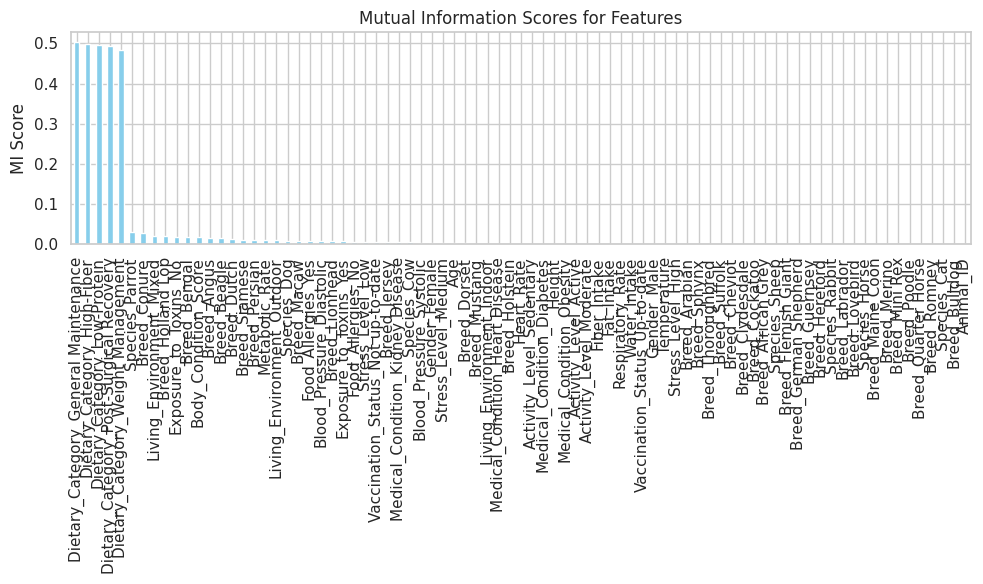

In [26]:
# ---------------------------------------------------------
# 1. Filter-based Feature Selection using Mutual Information
# ---------------------------------------------------------
print("=== Filter-based Feature Selection ===")
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_scores_series)

# Plot the mutual information scores for visual insight
plt.figure(figsize=(10, 6))
mi_scores_series.plot.bar(color='skyblue')
plt.title("Mutual Information Scores for Features")
plt.ylabel("MI Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Pearson Correlation with Target:
Dietary_Category_Post-Surgical Recovery    0.707107
Dietary_Category_High-Fiber                0.353553
Gender_Female                              0.051220
Exposure_to_Toxins_Yes                     0.044147
Breed_Conure                               0.032120
                                             ...   
Breed_Sphynx                              -0.043277
Exposure_to_Toxins_No                     -0.044147
Gender_Male                               -0.051220
Dietary_Category_Weight Management        -0.353553
Dietary_Category_General Maintenance      -0.707107
Length: 81, dtype: float64


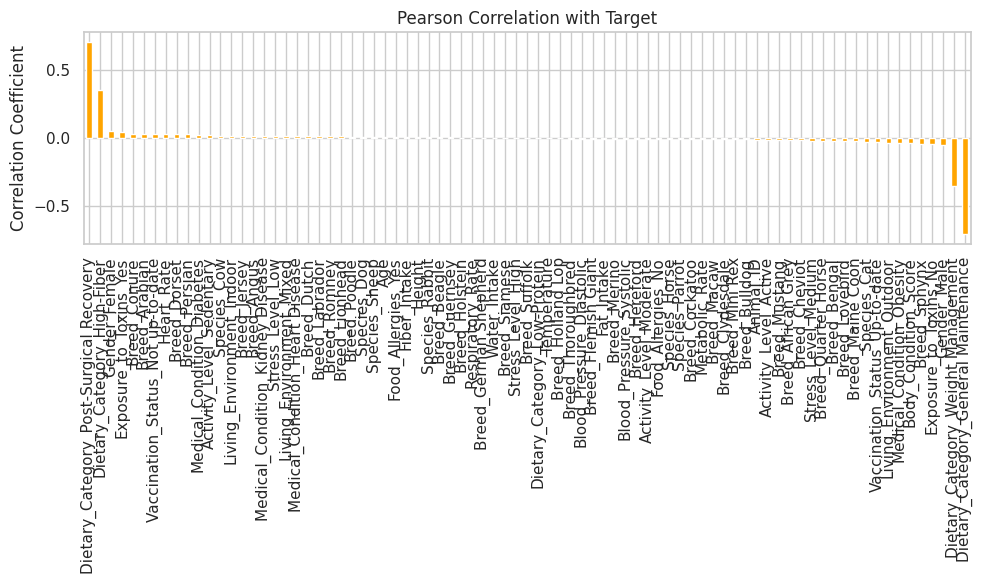

In [27]:
# (Optional) Compute Pearson correlation (caution: target is categorical)
corr = X.corrwith(y).sort_values(ascending=False)
print("Pearson Correlation with Target:")
print(corr)
plt.figure(figsize=(10, 6))
corr.plot.bar(color='orange')
plt.title("Pearson Correlation with Target")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
# ---------------------------------------------------------
# 2. Wrapper-based Feature Selection using Recursive Feature Elimination (RFE)
# ---------------------------------------------------------
print("=== Wrapper-based Feature Selection (RFE) ===")
# Use logistic regression (with L2 penalty) as the estimator
log_reg = LogisticRegression(max_iter=300, solver='saga', penalty='l2', random_state=42)
# Let's select the top 10 features as an example
rfe = RFE(estimator=log_reg, n_features_to_select=10)
rfe.fit(X, y)
rfe_features = X.columns[rfe.get_support()]
print("Features selected by RFE (Top 10):")
print(rfe_features)

=== Wrapper-based Feature Selection (RFE) ===
Features selected by RFE (Top 10):
Index(['Breed_Persian', 'Breed_Sphynx', 'Breed_Thoroughbred', 'Gender_Male',
       'Vaccination_Status_Up-to-date', 'Dietary_Category_General Maintenance',
       'Dietary_Category_High-Fiber', 'Dietary_Category_Low-Protein',
       'Dietary_Category_Post-Surgical Recovery',
       'Dietary_Category_Weight Management'],
      dtype='object')


In [29]:
# ---------------------------------------------------------
# 3. Embedded Method using L1 Regularization (LASSO for classification)
# ---------------------------------------------------------
print("=== Embedded Feature Selection (L1 Regularization) ===")
# Logistic Regression with L1 penalty acts like LASSO
log_reg_l1 = LogisticRegression(max_iter=300, solver='saga', penalty='l1', random_state=42)
log_reg_l1.fit(X, y)

=== Embedded Feature Selection (L1 Regularization) ===


LogisticRegression(max_iter=300, penalty='l1', random_state=42, solver='saga')

In [30]:
# Use SelectFromModel to choose features with non-zero coefficients.
# Here, we use the mean absolute coefficient as the threshold.
selector = SelectFromModel(log_reg_l1, prefit=True, threshold='mean')
embedded_features = X.columns[selector.get_support()]
print("Features selected by Embedded Method (L1):")
print(embedded_features)

Features selected by Embedded Method (L1):
Index(['Dietary_Category_General Maintenance', 'Dietary_Category_High-Fiber',
       'Dietary_Category_Low-Protein',
       'Dietary_Category_Post-Surgical Recovery',
       'Dietary_Category_Weight Management'],
      dtype='object')


In [31]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


**Model Implementation**

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

In [33]:
# Assume df_resampled is our balanced, preprocessed DataFrame with target "Dietary_Category"
# For tabular modeling, separate features and target:
X_tab = df_resampled.drop(columns=['Dietary_Category'])
y_tab = df_resampled['Dietary_Category']


In [34]:
# Split data into training and testing sets
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(X_tab, y_tab, test_size=0.2, random_state=42)


In [35]:
# Initialize a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, solver='saga', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "SVM": SVC(probability=True, random_state=42),
    "k-NN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=500, random_state=42)
}

In [36]:
from sklearn.metrics import accuracy_score, f1_score

In [37]:
# Train and evaluate each model
results = {}
print("=== Tabular Data Model Results ===")
for name, model in models.items():
    model.fit(X_train_tab, y_train_tab)
    y_pred = model.predict(X_test_tab)
    acc = accuracy_score(y_test_tab, y_pred)
    f1 = f1_score(y_test_tab, y_pred, average='weighted')
    results[name] = {"Accuracy": acc, "F1 Score": f1}
    print(f"{name}:\n  Accuracy: {acc:.4f}\n  F1 Score: {f1:.4f}\n")

=== Tabular Data Model Results ===
Logistic Regression:
  Accuracy: 1.0000
  F1 Score: 1.0000

Decision Tree:
  Accuracy: 1.0000
  F1 Score: 1.0000

Random Forest:
  Accuracy: 1.0000
  F1 Score: 1.0000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
  Accuracy: 1.0000
  F1 Score: 1.0000

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 2512, number of used features: 81
[LightGBM] [Info] Start training from score -1.665520
[LightGBM] [Info] Start training from score -1.590510
[LightGBM] [Info] Start training from score -1.598353
[LightGBM] [Info] Start training from score -1.596387
[LightGBM] [Info] Start training from score -1.598353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [38]:
# Ensemble Models: Stacking and Voting
estimators = [
    ('lr', LogisticRegression(max_iter=300, solver='saga', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('cat', CatBoostClassifier(random_state=42, verbose=0))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=300, random_state=42))
voting_model = VotingClassifier(estimators=estimators, voting='soft')

stacking_model.fit(X_train_tab, y_train_tab)
voting_model.fit(X_train_tab, y_train_tab)

for ens_model, ens_name in zip([stacking_model, voting_model], ['Stacking', 'Voting']):
    y_pred_ens = ens_model.predict(X_test_tab)
    acc = accuracy_score(y_test_tab, y_pred_ens)
    f1 = f1_score(y_test_tab, y_pred_ens, average='weighted')
    results[ens_name] = {"Accuracy": acc, "F1 Score": f1}
    print(f"{ens_name} Ensemble Model:\n  Accuracy: {acc:.4f}\n  F1 Score: {f1:.4f}\n")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:41:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:42:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacking Ensemble Model:
  Accuracy: 1.0000
  F1 Score: 1.0000

Voting Ensemble Model:
  Accuracy: 1.0000
  F1 Score: 1.0000



In [39]:
# Summary of Tabular Model Results
results_df = pd.DataFrame(results).T
print("Tabular Model Results Summary:")
print(results_df)

Tabular Model Results Summary:
                     Accuracy  F1 Score
Logistic Regression  1.000000  1.000000
Decision Tree        1.000000  1.000000
Random Forest        1.000000  1.000000
XGBoost              1.000000  1.000000
LightGBM             1.000000  1.000000
CatBoost             1.000000  1.000000
SVM                  1.000000  1.000000
k-NN                 0.592357  0.590951
MLP                  1.000000  1.000000
Stacking             1.000000  1.000000
Voting               1.000000  1.000000


In [40]:
# Define a custom PyTorch dataset for text data
class VeterinaryTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [41]:
# For the text models, we'll use the cleaned Veterinary Notes.
# Extract text data and corresponding target labels.
# We use the preprocessed column "Veterinary_Notes_Cleaned" from our dataset.
df_text = df_original.copy()  # 'df' here is our preprocessed DataFrame from Step 1.
# Convert target to numeric labels if not already numeric.
if df_text['Dietary_Category'].dtype not in [np.number]:
    df_text['Dietary_Category'], _ = pd.factorize(df_text['Dietary_Category'])

texts = df_processed['Veterinary_Notes_Cleaned'].tolist()
labels = df_text['Dietary_Category'].tolist()

<ipython-input-41-f87ff90f6b58>:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df_text['Dietary_Category'].dtype not in [np.number]:


In [42]:
# Split data for NLP fine-tuning (80-20 split)
from sklearn.model_selection import train_test_split
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [43]:
# Load BERT tokenizer and model for sequence classification
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = len(set(labels))
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Create dataset objects
max_length = 128
train_dataset = VeterinaryTextDataset(texts_train, labels_train, bert_tokenizer, max_length)
test_dataset = VeterinaryTextDataset(texts_test, labels_test, bert_tokenizer, max_length)


In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [46]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./bert_logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    seed=42
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [47]:
# Create Trainer instance
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=bert_tokenizer
)


<ipython-input-47-26e4c3060052>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [48]:
# Fine-tune the BERT model
print("Fine-tuning BERT for Veterinary Notes Classification...")
trainer.train()

Fine-tuning BERT for Veterinary Notes Classification...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: l215694 (l215694-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.616900,1.613880
2,1.598200,1.619375
3,1.604900,1.608901


TrainOutput(global_step=450, training_loss=1.617659166124132, metrics={'train_runtime': 9711.6448, 'train_samples_per_second': 0.741, 'train_steps_per_second': 0.046, 'total_flos': 473612656435200.0, 'train_loss': 1.617659166124132, 'epoch': 3.0})

In [49]:
# Evaluate the fine-tuned model
eval_results = trainer.evaluate()
print("BERT Evaluation Results:")
print(eval_results)

BERT Evaluation Results:
{'eval_loss': 1.6089013814926147, 'eval_runtime': 218.9461, 'eval_samples_per_second': 2.74, 'eval_steps_per_second': 0.174, 'epoch': 3.0}


**Multi-Modal Integration**

In [69]:
from sklearn.preprocessing import StandardScaler

# Scale tabular numerical features
scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tab)


In [70]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Function to extract BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT embeddings to text columns
X_vet_notes = np.array([get_bert_embedding(text) for text in df['Veterinary_Notes_Cleaned']])
X_prescription = np.array([get_bert_embedding(text) for text in df['Prescription_Cleaned']])
X_diet_recommendations = np.array([get_bert_embedding(text) for text in df['Dietary_Recommendations_Cleaned']])

# Concatenate text embeddings into a single feature set
X_text = np.concatenate([X_vet_notes, X_prescription, X_diet_recommendations], axis=1)


In [71]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout

# Define input layers
tabular_input = Input(shape=(X_tabular_scaled.shape[1],), name="tabular_input")
text_input = Input(shape=(X_text.shape[1],), name="text_input")  # BERT embeddings

# Tabular Feature Network
tabular_dense = Dense(128, activation="relu")(tabular_input)
tabular_dense = Dropout(0.3)(tabular_dense)
tabular_dense = Dense(64, activation="relu")(tabular_dense)

# Text Feature Network
text_dense = Dense(128, activation="relu")(text_input)
text_dense = Dropout(0.3)(text_dense)
text_dense = Dense(64, activation="relu")(text_dense)

# Fusion Layer (Combining Tabular & Text Features)
merged = Concatenate()([tabular_dense, text_dense])
merged = Dense(64, activation="relu")(merged)
merged = Dropout(0.3)(merged)

# Output Layer for Classification
output = Dense(num_classes, activation="softmax")(merged)

# Define Model
multi_modal_model = Model(inputs=[tabular_input, text_input], outputs=output)

# Compile Model
multi_modal_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Summary of the Model
multi_modal_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 81)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 2304)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 128)            │         10,496 │ tabular_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │        295,040 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ dense_21[0][0],        │
│ (Concatenate)             │                        │                │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │          8,256 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 5)              │            325 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 330,629 (1.26 MB)

 Trainable params: 330,629 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
print(f"X_tabular_scaled shape: {X_tabular_scaled.shape}")
print(f"X_text shape: {X_text.shape}")
print(f"y shape: {y.shape}")


X_tabular_scaled shape: (3140, 81)
X_text shape: (3000, 2304)
y shape: (3140,)


In [79]:
# Find minimum number of samples among all inputs
min_samples = min(len(X_tabular_scaled), len(X_text), len(y))

# Trim all datasets to match the smallest size
X_tabular_scaled = X_tabular_scaled[:min_samples]
X_text = X_text[:min_samples]
y = y[:min_samples]

# Now check the shapes again
print(f"Fixed X_tabular_scaled shape: {X_tabular_scaled.shape}")
print(f"Fixed X_text shape: {X_text.shape}")
print(f"Fixed y shape: {y.shape}")


Fixed X_tabular_scaled shape: (3000, 81)
Fixed X_text shape: (3000, 2304)
Fixed y shape: (3000,)


In [80]:
from sklearn.model_selection import train_test_split

# First, split into train and test sets (80% train, 20% test)
X_tabular_train, X_tabular_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_tabular_scaled, X_text, y, test_size=0.2, random_state=42, stratify=y
)

# Then, split train set further into train and validation sets (80% train, 20% validation)
X_tabular_train, X_tabular_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_tabular_train, X_text_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train, Validation, and Test sets successfully created!")


Train, Validation, and Test sets successfully created!


In [82]:
multi_modal_model.fit(
    [X_tabular_train, X_text_train], y_train,
    epochs=30,
    batch_size=32,
    validation_data=([X_tabular_val, X_text_val], y_val)
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2597 - loss: 1.6050 - val_accuracy: 0.6917 - val_loss: 1.1298
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6722 - loss: 0.9331 - val_accuracy: 0.9917 - val_loss: 0.1371
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9615 - loss: 0.1944 - val_accuracy: 1.0000 - val_loss: 0.0152
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9923 - loss: 0.0576 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9965 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 8.2803e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9948 - loss: 0.0183 - val_accuracy: 1.0000 - val_loss: 3.0053e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 1.2544e-04
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy

In [83]:
# Evaluate on test set
test_loss, test_accuracy = multi_modal_model.evaluate([X_tabular_test, X_text_test], y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.1215e-07
Test Accuracy: 1.0000


In [84]:
print(f"X_tabular_train shape: {X_tabular_train.shape}")
print(f"X_tabular_val shape: {X_tabular_val.shape}")
print(f"X_tabular_test shape: {X_tabular_test.shape}")
print(f"X_text_train shape: {X_text_train.shape}")
print(f"X_text_val shape: {X_text_val.shape}")
print(f"X_text_test shape: {X_text_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_tabular_train shape: (1920, 81)
X_tabular_val shape: (480, 81)
X_tabular_test shape: (600, 81)
X_text_train shape: (1920, 2304)
X_text_val shape: (480, 2304)
X_text_test shape: (600, 2304)
y_train shape: (1920,)
y_val shape: (480,)
y_test shape: (600,)


In [92]:
from transformers import pipeline

# Use GPT-Neo 125M model as an open-source alternative
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-125M")

def generate_synthetic_vet_notes(prompt):
    # Generate synthetic text with a maximum length of 100 tokens
    generated = generator(prompt, max_length=100, num_return_sequences=1)
    return generated[0]['generated_text']

# Example synthetic data generation
rare_case_prompt = "Generate a detailed veterinary note for a rare genetic disorder in felines."
synthetic_vet_note = generate_synthetic_vet_notes(rare_case_prompt)
print("Synthetic Veterinary Note:\n", synthetic_vet_note)


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Synthetic Veterinary Note:
 Generate a detailed veterinary note for a rare genetic disorder in felines.

The disease is a rare autosomal recessive disorder in which the disease is caused by mutations in the gene for the human protein tyrosine kinase receptor tyrosine kinase receptor (TKR). The disease is characterized by a severe clinical picture, which includes a severe clinical picture of the disease, and a severe clinical picture of the disease itself. The disease is also known as the “felon


**Hyperparameter Tuning**

In [98]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For this example, we'll use the tabular training set from your resampled data
# X_train and y_train should be defined, for example:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a dictionary of models and their parameter grids for tuning
model_param_grid = {
    "LogisticRegression": (
        LogisticRegression(max_iter=300, solver='saga', random_state=42),
        {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 300, 500],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    )
}

# Dictionary to store the best estimators after hyperparameter tuning
best_estimators = {}

# Loop over each model and perform GridSearchCV
for model_name, (model, param_grid) in model_param_grid.items():
    print(f"\nTuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_tabular_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best CV score: {grid_search.best_score_:.4f}")

# Optionally, convert results to a DataFrame for a summary report
results_summary = pd.DataFrame({
    model_name: {
        "Best Params": grid_search.best_params_,
        "Best CV Score": grid_search.best_score_
    }
    for model_name, (model, param_grid) in model_param_grid.items()  # Added .items() to iterate through key-value pairs
    for grid_search in [GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1).fit(X_tabular_train, y_train)]  # Changed X_train to X_tabular_train
}).T

print("\nSummary of Hyperparameter Tuning:")
print(results_summary)



Tuning hyperparameters for LogisticRegression...
LogisticRegression best parameters: {'C': 0.001, 'penalty': 'l2'}
LogisticRegression best CV score: 1.0000

Tuning hyperparameters for DecisionTree...
DecisionTree best parameters: {'max_depth': None, 'min_samples_split': 2}
DecisionTree best CV score: 1.0000

Tuning hyperparameters for RandomForest...
RandomForest best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest best CV score: 1.0000

Tuning hyperparameters for GradientBoosting...
GradientBoosting best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
GradientBoosting best CV score: 1.0000

Tuning hyperparameters for SVM...
SVM best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM best CV score: 1.0000

Tuning hyperparameters for KNN...
KNN best parameters: {'n_neighbors': 9, 'weights': 'distance'}
KNN best CV score: 0.7141

Summary of Hyperparameter Tuning:
                                            

**Explainable AI (XAI)**

In [97]:
pip install shap lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a2d5ea0726f9627219707e70cb74db5ddb2ce85311328074928d877e4a115cb5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [99]:
# -----------------------------
# Step 8: Explainable AI (XAI)
# -----------------------------

import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Generating SHAP Summary Plot (Bar Plot) ...


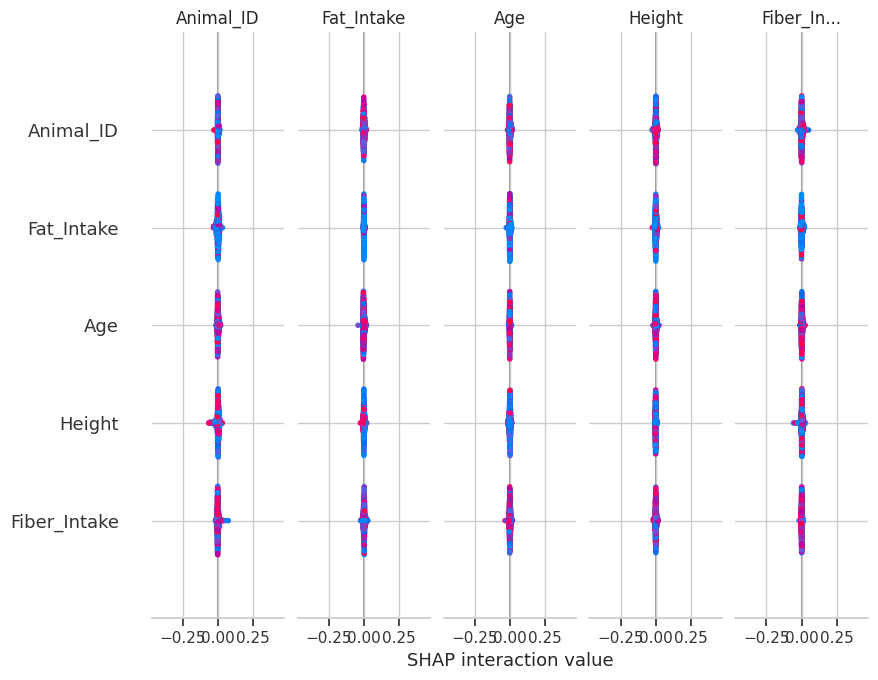

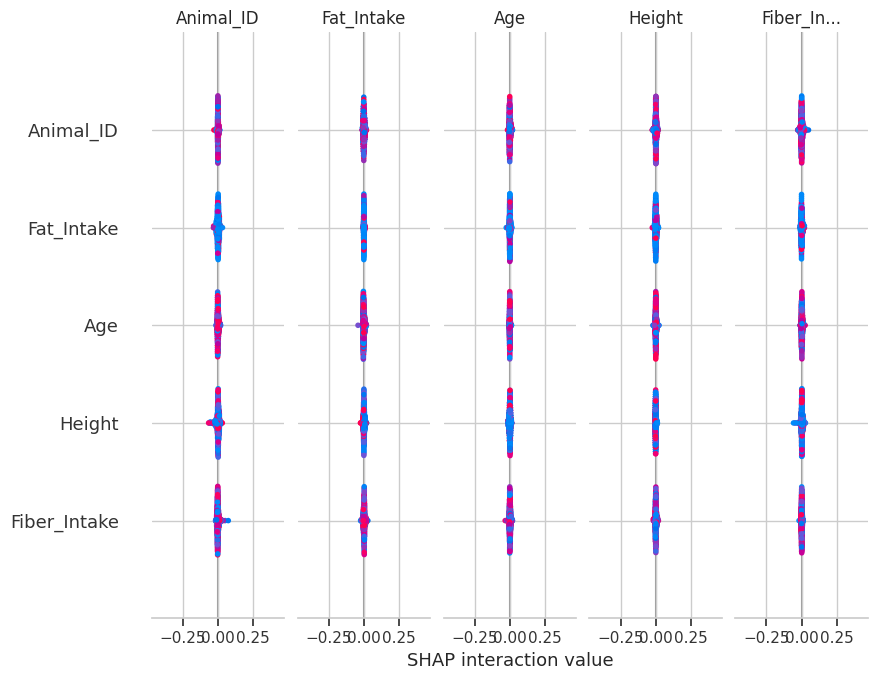

In [105]:
# Part A: SHAP for Tree-Based Models
# =============================
# We'll use the best RandomForestClassifier (rf_model) obtained from hyperparameter tuning.
# If our model is stored in 'best_estimators["RandomForest"]', use that.
# Here, we assume rf_model is defined and already trained.
# Also, we assume X_test_tab is your test set for tabular data.
rf_model = best_estimators["RandomForest"]
# Create a SHAP TreeExplainer for the Random Forest model
explainer_shap = shap.TreeExplainer(rf_model)
shap_values = explainer_shap.shap_values(X_test_tab)

# Plot a SHAP summary plot (bar plot version for feature importance)
print("Generating SHAP Summary Plot (Bar Plot) ...")
shap.summary_plot(shap_values, X_test_tab, plot_type="bar")

# Optionally, you can also view the detailed summary plot (beeswarm plot)
# Uncomment the following line if desired:
shap.summary_plot(shap_values, X_test_tab)

In [106]:
# =============================
# Part B: LIME for Tabular Data
# =============================
# Prepare the LIME explainer using training data (X_train_tab)
feature_names = X_train_tab.columns.tolist()
# Create class names based on unique values in y_train; convert to strings.
class_names = [str(cls) for cls in sorted(y_train.unique())]

lime_explainer = LimeTabularExplainer(
    X_train_tab.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Choose a sample instance from the test set to explain (e.g., the first instance)
instance_idx = 0
instance = X_test_tab.iloc[instance_idx]

# Generate a LIME explanation for the instance using the Random Forest model's predict_proba
exp = lime_explainer.explain_instance(instance.values, rf_model.predict_proba, num_features=10)


In [113]:
# Get available labels by calling the method
available_labels = exp.available_labels()
print("Available labels in the explanation:", available_labels)

# Use predicted_label if available; otherwise, default to the first available label.
if predicted_label in available_labels:
    label_to_use = predicted_label
else:
    label_to_use = available_labels[0]
    print(f"Predicted label {predicted_label} not found. Using label {label_to_use} instead.")

print("\nLIME Explanation for Sample Instance (Feature contributions):")
for feature, weight in exp.as_list(label=label_to_use):
    print(f"{feature}: {weight:.4f}")


Available labels in the explanation: [1]
Predicted label 4 not found. Using label 1 instead.

LIME Explanation for Sample Instance (Feature contributions):
Dietary_Category_Weight Management <= 0.00: -0.5625
Dietary_Category_High-Fiber <= 0.00: 0.1224
Dietary_Category_General Maintenance <= 0.00: 0.1194
Dietary_Category_Low-Protein <= 0.00: 0.1107
Dietary_Category_Post-Surgical Recovery > 0.00: -0.1035
Breed_Dutch <= 0.00: 0.0133
Breed_Merino <= 0.00: 0.0132
Breed_Lovebird <= 0.00: -0.0114
Breed_Thoroughbred <= 0.00: 0.0111
Breed_Holland Lop <= 0.00: 0.0106



Generating LIME Explanation Plot...


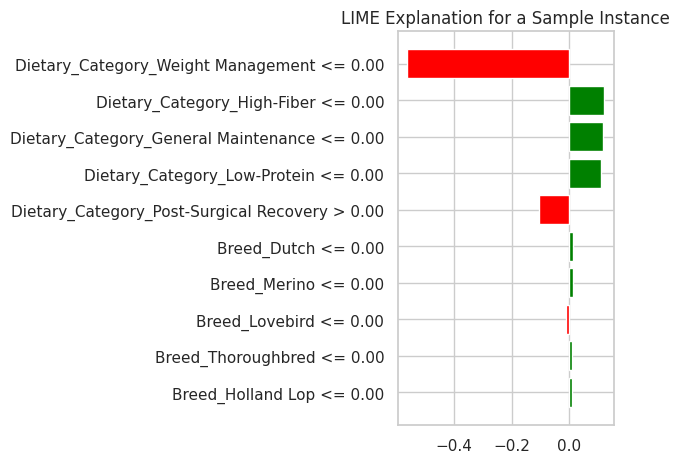

In [114]:
# Plot the LIME explanation using matplotlib
print("\nGenerating LIME Explanation Plot...")
lime_fig = exp.as_pyplot_figure()
plt.title("LIME Explanation for a Sample Instance")
plt.tight_layout()
plt.show()

**Performance Evaluation**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix:
 [[153   0   0   0   0]
 [  0 116   0   0   0]
 [  0   0 120   0   0]
 [  0   0   0 119   0]
 [  0   0   0   0 120]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       116
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       119
           4       1.00      1.00      1.00       120

    accuracy                           1.00       628
   macro avg       1.00      1.00      1.00       628
weighted avg       1.00      1.00      1.00       628

Classification Performance Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Sensitivity (Macro Average): 1.0000
Specificity (Macro Average): 1.0000


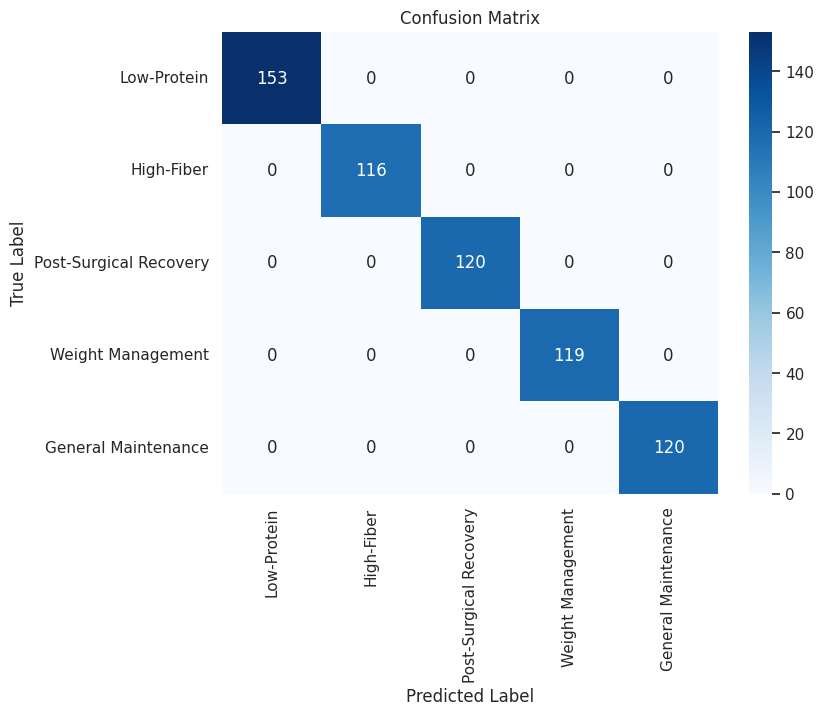

In [136]:
# Import required libraries for performance evaluation
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_squared_error, r2_score, classification_report)
import matplotlib.pyplot as plt

def evaluate_classification(y_true, y_pred, average='weighted'):
    """
    Evaluate classification performance and compute:
        - Accuracy, Precision, Recall, F1-score
        - Sensitivity and Specificity (computed per class then macro averaged)
    """
    # Overall classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)

    # Confusion matrix for detailed analysis
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Compute sensitivity and specificity for each class
    sensitivity_list = []
    specificity_list = []
    n_classes = cm.shape[0]
    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)

    # Macro-averaged sensitivity and specificity
    sensitivity_macro = np.mean(sensitivity_list)
    specificity_macro = np.mean(specificity_list)

    # Create a summary dictionary
    results = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Sensitivity (Macro Average)": sensitivity_macro,
        "Specificity (Macro Average)": specificity_macro
    }

    # Print detailed classification report
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    return results

def evaluate_regression(y_true, y_pred):
    """
    Evaluate regression performance and compute:
        - Mean Squared Error (MSE)
        - R² Score
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results = {
        "MSE": mse,
        "R2 Score": r2
    }
    return results

trained_model = best_estimators.get("RandomForest")
y_pred = trained_model.predict(X_test_tab)


# Uncomment and modify the following code when you have predictions:
results_classification = evaluate_classification(y_test_tab, y_pred) #use y_test_tab since it's the test set from the tabular models
print("Classification Performance Metrics:")
for metric, value in results_classification.items():
     print(f"{metric}: {value:.4f}")


# For regression (if needed), use:
#y_reg_pred = trained_regression_model.predict(X_test_reg)
#results_regression = evaluate_regression(y_test_reg, y_reg_pred)
#print("Regression Performance Metrics:")
#for metric, value in results_regression.items():
#     print(f"{metric}: {value:.4f}")


def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

# Example call for plotting, if classes are known:
classes = ['Low-Protein', 'High-Fiber', 'Post-Surgical Recovery', 'Weight Management', 'General Maintenance']
plot_confusion_matrix(y_test_tab, y_pred, classes) #changed y_test to y_test_tab


Multi-Modal Model Test Loss: 0.0000
Multi-Modal Model Test Accuracy: 1.0000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00       125
           2       1.00      1.00      1.00       126
           3       1.00      1.00      1.00       125
           4       1.00      1.00      1.00        98

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



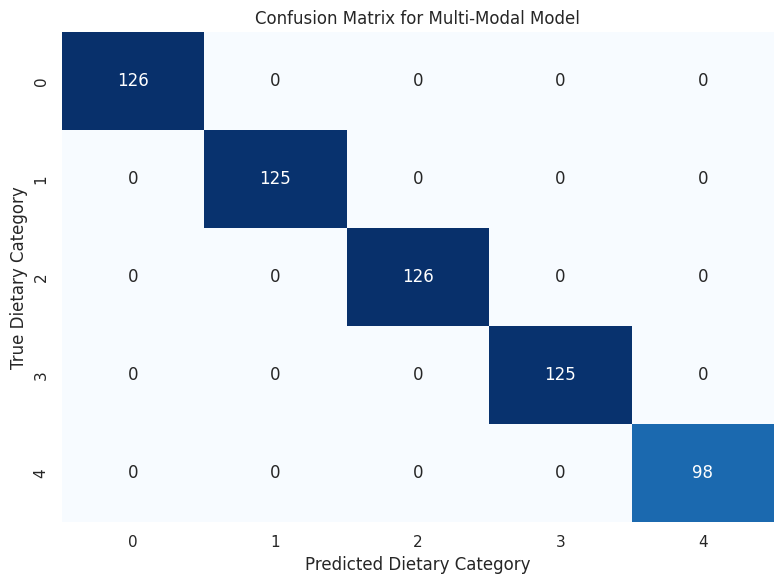

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Evaluate the Multi-Modal Model
# ------------------------------

# Evaluate on test set (returns loss and accuracy)
test_loss, test_accuracy = multi_modal_model.evaluate([X_tabular_test, X_text_test], y_test, verbose=0)
print("Multi-Modal Model Test Loss: {:.4f}".format(test_loss))
print("Multi-Modal Model Test Accuracy: {:.4f}".format(test_accuracy))

# ------------------------------
# Generate Predictions
# ------------------------------

# Predict class probabilities and convert to predicted class labels
y_pred_proba = multi_modal_model.predict([X_tabular_test, X_text_test])
y_pred = np.argmax(y_pred_proba, axis=1)

# ------------------------------
# Classification Report
# ------------------------------

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# ------------------------------
# Plot Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Multi-Modal Model")
plt.xlabel("Predicted Dietary Category")
plt.ylabel("True Dietary Category")
plt.tight_layout()
plt.show()
